
# Week 2 — Baseline Prediction Models & Evaluation

In this notebook, you will build **baseline prediction models** for financial
returns and evaluate them using **strictly forward-looking (time-series)
validation**.

This week focuses on **evaluation discipline**, not on maximizing performance.


## 1. Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

plt.style.use("seaborn-v0_8")


## 2. Load data from Week 1

- Reuse the data you created in Week 1.
- You can use one stock of your choice (you can repeat it for multiple stocks if you want and plot them separately)
- Take a long term horizon data set (5-10 years)


In [ ]:
# TODO: load prices and returns from Week 1
import yfinance as yf

tickers = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'TSLA']
start_date = "2015-01-01"
end_date = "2024-01-01"

data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=False)

[*********************100%***********************]  5 of 5 completed



## 3. Feature construction

Required features:
- $r_t$
- $r_{t-1}$
- 20-day rolling mean
- 20-day rolling volatility
- 5-day momentum


In [ ]:

# TODO: construct features using only past data
import numpy as np
import pandas as pd

ticker = 'AAPL'
df = pd.DataFrame(data['Adj Close'][ticker].copy())
df.columns = ['Price']

df['r_t'] = np.log(df['Price']).diff()

df['r_t-1'] = df['r_t'].shift(1)

df['mean_20'] = df['r_t'].rolling(window=20).mean()

df['vol_20'] = df['r_t'].rolling(window=20).std()

df['mom_5'] = df['r_t'].rolling(window=5).sum()

df_features = df.dropna()

print(f"Features constructed for {ticker}:")
print(df_features[['r_t', 'r_t-1', 'mean_20', 'vol_20', 'mom_5']].tail())

Features constructed for AAPL:
                 r_t     r_t-1   mean_20    vol_20     mom_5
Date                                                        
2023-12-22 -0.005563 -0.000770  0.000946  0.009045 -0.020299
2023-12-26 -0.002845 -0.005563  0.000852  0.009075 -0.014604
2023-12-27  0.000518 -0.002845  0.000717  0.009059 -0.019432
2023-12-28  0.002224  0.000518  0.001099  0.008946 -0.006437
2023-12-29 -0.005439  0.002224  0.000675  0.009050 -0.011105



## 4. Naive baselines


In [4]:

# TODO: zero predictor
df_features['pred_zero'] = 0.0

C:\Users\satya\AppData\Local\Temp\ipykernel_26632\1728224254.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features['pred_zero'] = 0.0


In [6]:
# TODO: rolling mean predictor
df_features['pred_rolling'] = df_features['mean_20'].shift(1)
df_features = df_features.dropna()

C:\Users\satya\AppData\Local\Temp\ipykernel_26632\3774096758.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features['pred_rolling'] = df_features['mean_20'].shift(1)



## 5. Linear models (OLS & Ridge)
Suggested that you review basic linear regression theory as well (resources given in README).

In [9]:

# use LinearRegression from sklearn
from sklearn.linear_model import Ridge
feature_cols = ['r_t-1', 'mean_20', 'vol_20', 'mom_5']
target_col = 'r_t'

X = df_features[feature_cols]
y = df_features[target_col]

split_point = int(len(X) * 0.8)

X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]
y_train, y_test = y.iloc[:split_point], y.iloc[split_point:]

print(f"Training on {len(X_train)} days (Past)")
print(f"Testing on {len(X_test)} days (Future)")

model_ols = LinearRegression()
model_ols.fit(X_train, y_train)

pred_ols = model_ols.predict(X_test)
#save predictions to the dataframe for later comparison
df_features.loc[X_test.index, 'pred_OLS'] = pred_ols

model_ridge = Ridge(alpha=1.0)
model_ridge.fit(X_train, y_train)

#predict
pred_ridge = model_ridge.predict(X_test)
df_features.loc[X_test.index, 'pred_Ridge'] = pred_ridge

Training on 1794 days (Past)
Testing on 449 days (Future)



## 6. Tree-based model (Random Forest) (optional)


In [10]:

rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=5,
    min_samples_leaf=50,
    random_state=42
)
rf.fit(X_train, y_train)

pred_rf = rf.predict(X_test)

df_features.loc[X_test.index, 'pred_RF'] = pred_rf


## 7. Walk-forward evaluation

- Scikit reference for [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html).

In [16]:

# TODO: implement TimeSeriesSplit evaluation
tscv = TimeSeriesSplit(n_splits=5)



## 8. Prediction accuracy


In [25]:

# TODO: compute RMSE for all models and compare them
X = df_features[['r_t-1', 'mean_20', 'vol_20', 'mom_5']]
y = df_features['r_t']
cv_results = {
    'OLS': [],
    'Ridge': [],
    'RandomForest': [],
    'Zero_Baseline': []
}
for split_i, (train_index, test_index) in enumerate(tscv.split(X)):
    
    X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
    y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]
    
    model_ols.fit(X_train_cv, y_train_cv)
    pred_ols = model_ols.predict(X_test_cv)
    cv_results['OLS'].append(np.sqrt(mean_squared_error(y_test_cv, pred_ols)))
    
    model_ridge.fit(X_train_cv, y_train_cv)
    pred_ridge = model_ridge.predict(X_test_cv)
    cv_results['Ridge'].append(np.sqrt(mean_squared_error(y_test_cv, pred_ridge)))
    
    rf.fit(X_train_cv, y_train_cv)
    pred_rf = rf.predict(X_test_cv)
    cv_results['RandomForest'].append(np.sqrt(mean_squared_error(y_test_cv, pred_rf)))

    pred_zero = np.zeros_like(y_test_cv)
    cv_results['Zero_Baseline'].append(np.sqrt(mean_squared_error(y_test_cv, pred_zero)))

print("--- Final Model Comparison (Walk-Forward RMSE) ---")
results_df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in cv_results.items() ]))
mean_rmse = results_df.mean().sort_values()
print(mean_rmse)

# Check who won
winner = mean_rmse.index[0]
print(f"\nbest model is: {winner}")

--- Final Model Comparison (Walk-Forward RMSE) ---
OLS              0.015508
RandomForest     0.016190
Ridge            0.016496
Zero_Baseline    0.018008
dtype: float64

best model is: OLS


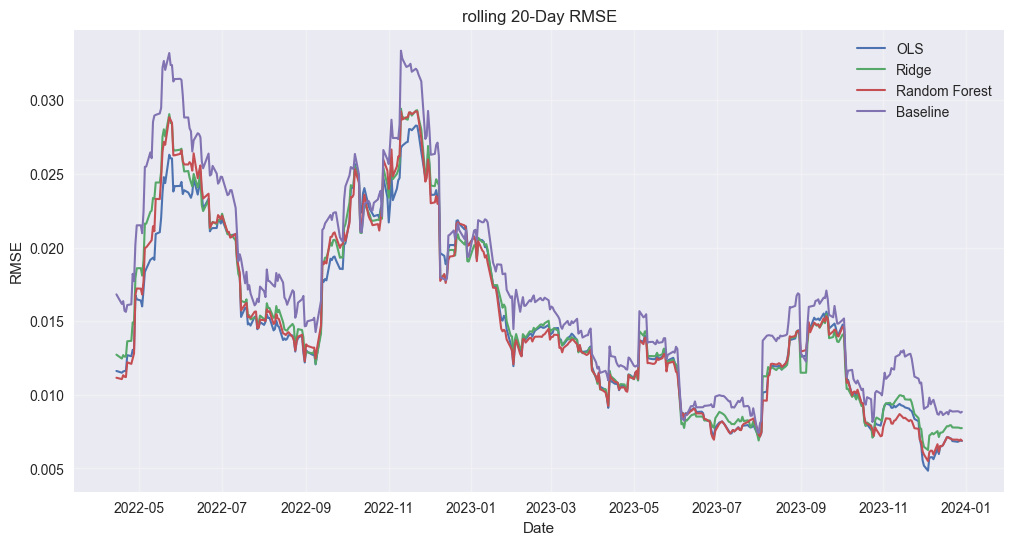

In [27]:
# TODO: plot rolling RMSE vs time for all models to compare their performance across different time periods/regimes
df_test = df_features.dropna(subset=['pred_OLS'])
target = df_test['r_t']

errors_sq = pd.DataFrame()
errors_sq['OLS'] = (target - df_test['pred_OLS']) ** 2
errors_sq['Ridge'] = (target - df_test['pred_Ridge']) ** 2
if 'pred_RF' in df_test.columns:
    errors_sq['Random Forest'] = (target - df_test['pred_RF']) ** 2

errors_sq['Baseline'] = (target - 0.0) ** 2

rolling_rmse = np.sqrt(errors_sq.rolling(window=20).mean())

plt.figure(figsize=(12, 6))
plt.plot(rolling_rmse, linewidth=1.5)
plt.title('rolling 20-Day RMSE')
plt.ylabel('RMSE')
plt.xlabel('Date')
plt.legend(rolling_rmse.columns)
plt.grid(True, alpha=0.3)
plt.show()

In [31]:
# Bonus: compute volatility scaled/normalized prediction error: sqrt( ((y_true - y_pred)**2) / (vol_t**2) ) - and compare across models
volatility = df_test['vol_20']

scaled_errors = pd.DataFrame()
for col in errors_sq.columns:
    scaled_errors[col] = np.sqrt(errors_sq[col] / (volatility ** 2))

print(scaled_errors.mean().sort_values())

Random Forest    0.682332
OLS              0.690944
Ridge            0.699710
Baseline         0.776756
dtype: float64


## 9. Bonus: Looking at a toy strategy based on predictions
Define a simple "all-in" strategy where you go all long (+1) when you predict the stock to be going up, and all short (-1) when you predict the stock to be going down
$$
\text{position}_t = \text{sign}(y_\text{pred})
$$
Then, your returns for the $t$-th day (assuming daily returns) will be $(\text{position}_t \times y_\text{true})$ (note $y_\text{true} = r_t$).

Note that this is extremely simplistic and ignore any predictions related magnitude of expected returns, or expected volatility data etc. It is used only as a demonstration of what a prediction-based strategy may look like.

**Plot your returns using this strategy based on all the models above and compare them!**

In [35]:
# TODO: compute the positions for each model and daily returns
def calculate_strategy_returns(df, pred_col, target_col='r_t'):    
    position = np.sign(df[pred_col])
    strategy_ret = position * df[target_col]
    return strategy_ret

df_test = df_features.dropna(subset=['pred_OLS']).copy()

df_test['strat_BuyHold'] = df_test['r_t']

df_test['strat_OLS'] = calculate_strategy_returns(df_test, 'pred_OLS')
df_test['strat_Ridge'] = calculate_strategy_returns(df_test, 'pred_Ridge')

if 'pred_RF' in df_test.columns:
    df_test['strat_RF'] = calculate_strategy_returns(df_test, 'pred_RF')

cumulative_returns = df_test[['strat_BuyHold', 'strat_OLS', 'strat_Ridge', 'strat_RF']].cumsum()


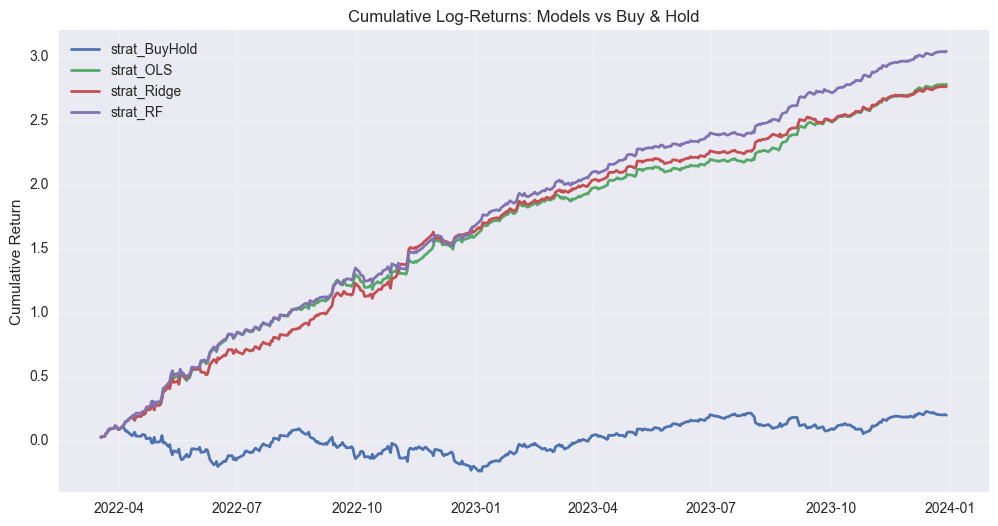

In [36]:
# TODO: plot your returns
plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns, linewidth=2)
plt.title('Cumulative Log-Returns: Models vs Buy & Hold')
plt.ylabel('Cumulative Return')
plt.legend(cumulative_returns.columns)
plt.grid(True, alpha=0.3)
plt.show()


## 10. Discussion questions

1. Why do we need naive baselines?
2. How does the evaluation strategy here (walk-forward evaluation) differ from the random training-test dataset splits used in convention ML?
3. *(Addon)* And, why does random splitting technique fail here?
4. Interpret the RMSE values and rolling RMSE plot results very briefly.
5. *(Addon)* Are there periods where model performance degrades noticeably? What might this indicate?
6. Why might Random Forest overfit?
7. *(Bonus)* Two models have similar RMSE, but one makes larger errors primarily during high-volatility periods. Why might this model be *less dangerous* in a portfolio context?

1. To set a minimum expectation. Financial data is incredibly noisy, a complex AI model might look like its working but actually performs worse than simply guessing 0 every day. If we cant beat the baseline, model is adding no value.

2. Random split shuffles days like a deck of cards. It might train on data from 2023 to predict prices in 2015. This is cheating (look-ahead bias). Walk-Forward strictly respects time. It trains on 2015–2020 to predict 2021. It mimics real-world trading where you never have tomorrows data.

3. Because stock prices are autocorrelated. If you randomly split, you destroy the time structure, and your model learns to interpolate missing days rather than predict the future.

4. A lower RMSE is better. The Rolling RMSE plot typically shows spikes during volatile periods. This tells us that our models are not universally good as they fail when the market behaves unpredictably.

5. Yes, usually during high volatility periods. This indicates that the relationships the model learned during normal times break down when the market panics.

6. Random Forests can learn extremely specific rules. In finance, that specific value is likely just noise. If we don't limit the tree depth (using max_depth), it memorizes the noise instead of the trend.

7. Because in high volatility, risk management systems naturally tell you to trade smaller sizes. A model that fails when everyone knows the market is crazy is manageable. A model that fails randomly during calm periods is a hidden trap.